<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Timeseries Forecasting with LSTM on Stock Data

_Authors: Kiefer Katovich (SF)_

---

In this lab you will practice building LSTMs with Keras to fit and predict on timeseries data. In particular, you will be pulling down stock price data using a matplotlib package (code provided).

This lab mirrors in large part the Keras LSTM code in the lecture, so please see that for reference.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

sns.set_style('whitegrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### 1. Import the required Keras packages

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


### 2. Load the data

In [3]:
files = ['ge.us.txt',
        'ibm.us.txt',
        'mo.us.txt',
        'hpq.us.txt',
        'ko.us.txt',
        'xom.us.txt',
        'mrk.us.txt',
        'utx.us.txt']

startdate = '2005-01-01'
enddate = '2010-01-01'

stocks = pd.DataFrame()

for filename in files:
    print(filename)
    stock = filename.split('.')[0]
    df_stock = pd.read_csv('../data/'+filename)[['Date','Close']]\
                 .rename(columns={'Close':stock})
    df_stock['Date'] = pd.to_datetime(df_stock['Date'])
    print(df_stock[stock].tail(3).reset_index())
    df_stock = df_stock[(df_stock['Date']>=startdate) & (df_stock['Date']<enddate)].reset_index()
    stocks[stock] = df_stock[stock]

ge.us.txt
   index     ge
0  14055  20.12
1  14056  19.99
2  14057  20.49
ibm.us.txt
   index     ibm
0  14056  150.07
1  14057  150.30
2  14058  149.16
mo.us.txt
   index     mo
0  12071  64.59
1  12072  64.51
2  12073  65.02
hpq.us.txt
   index    hpq
0  12072  21.42
1  12073  21.34
2  12074  21.23
ko.us.txt
   index     ko
0  12072  46.18
1  12073  46.23
2  12074  46.54
xom.us.txt
   index     xom
0  12071  82.705
1  12072  83.200
2  12073  82.940
mrk.us.txt
   index    mrk
0  12072  56.58
1  12073  56.21
2  12074  55.48
utx.us.txt
   index     utx
0  12069  120.28
1  12070  118.37
2  12071  118.11


### 5. Normalize the data to the range -1 to 1

In [4]:
mms = MinMaxScaler(feature_range=(-1,1))
stocks_norm = pd.DataFrame(mms.fit_transform(stocks), columns=stocks.columns)

In [5]:
stocks_norm.head()

,ge,ibm,mo,hpq,ko,xom,mrk,utx
0,0.688104,-0.145062,-0.996323,-0.899672,-0.733982,-0.974030,-0.483758,-0.373646
1,0.663374,-0.179546,-0.977410,-0.907831,-0.775752,-0.988925,-0.490152,-0.400089
2,0.650974,-0.186041,-0.981350,-0.902478,-0.789381,-1.000000,-0.479665,-0.417613
3,0.667437,-0.196000,-1.000000,-0.904855,-0.765487,-0.972612,-0.470137,-0.416249
4,0.654757,-0.209739,-0.962438,-0.911956,-0.761416,-0.987179,-0.490152,-0.440594


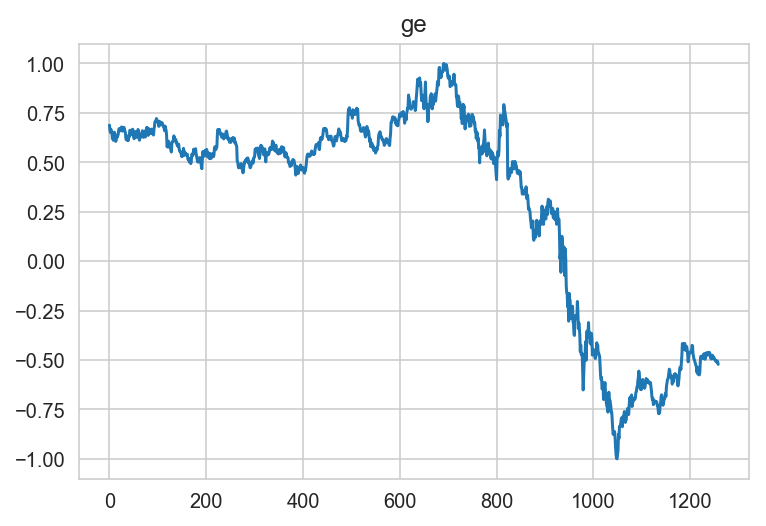

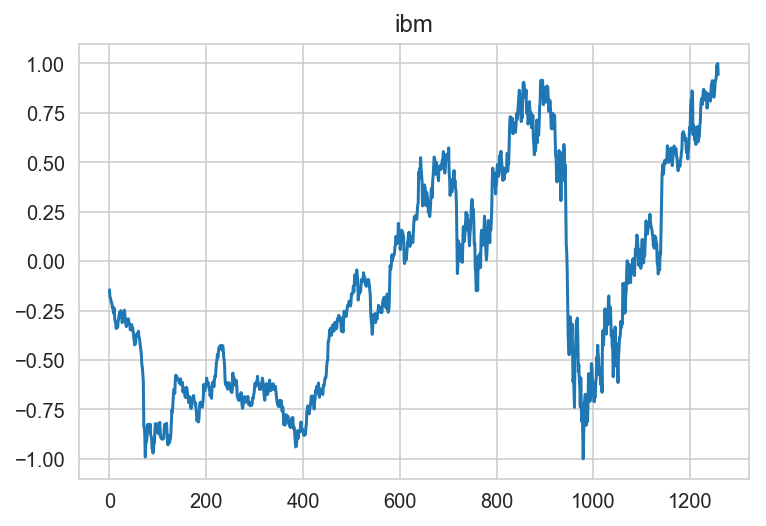

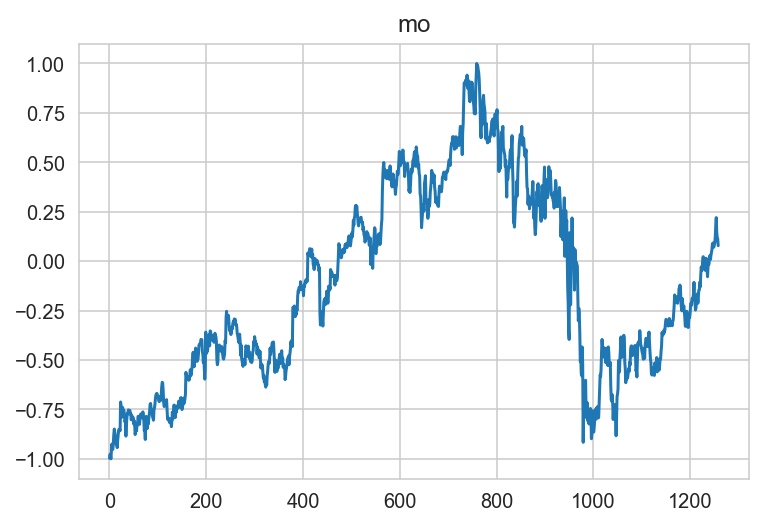

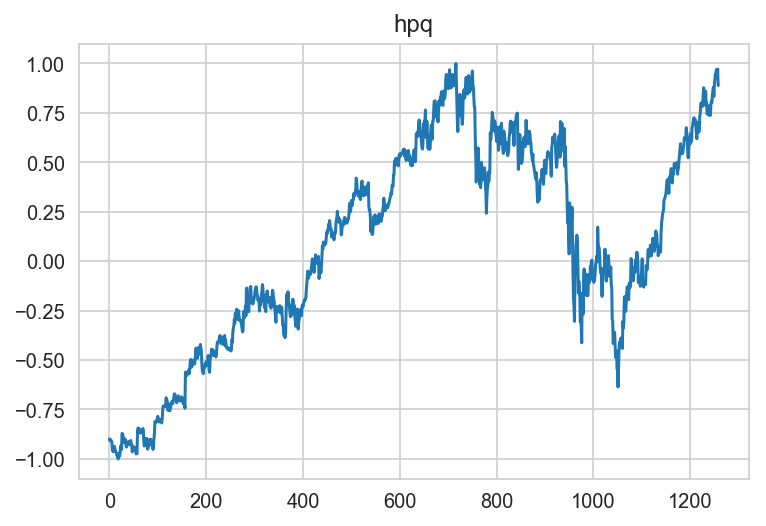

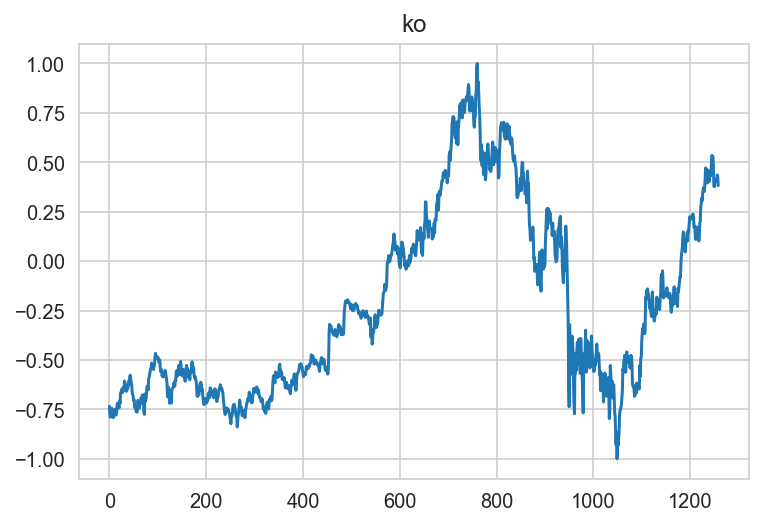

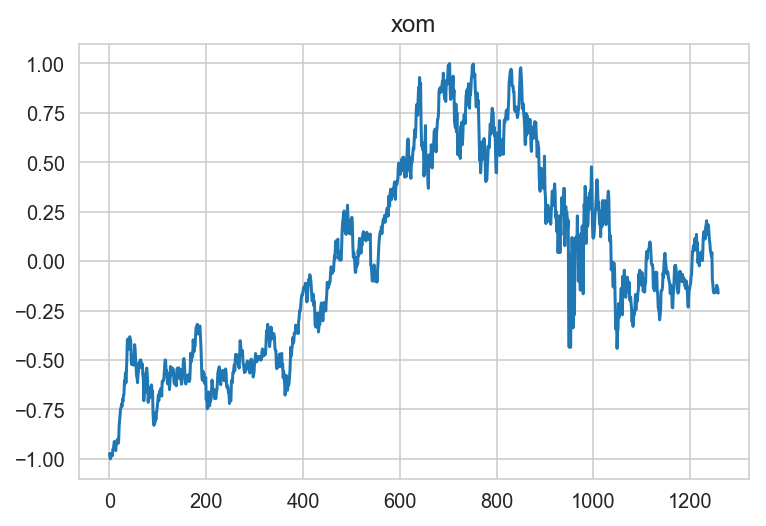

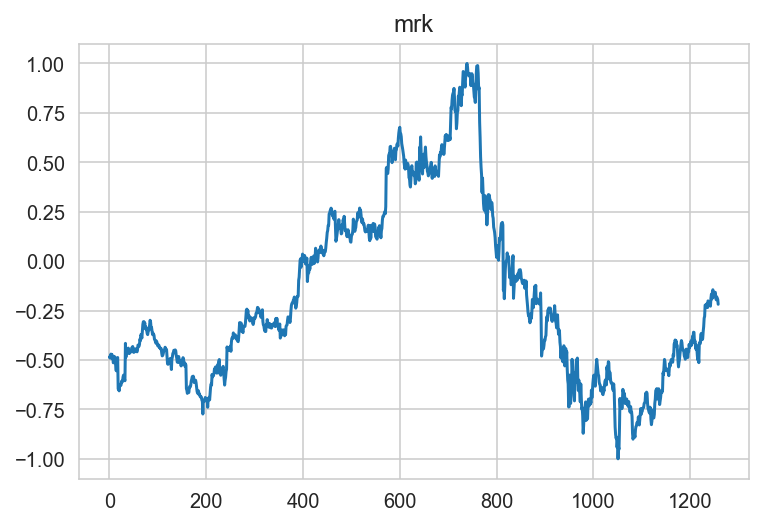

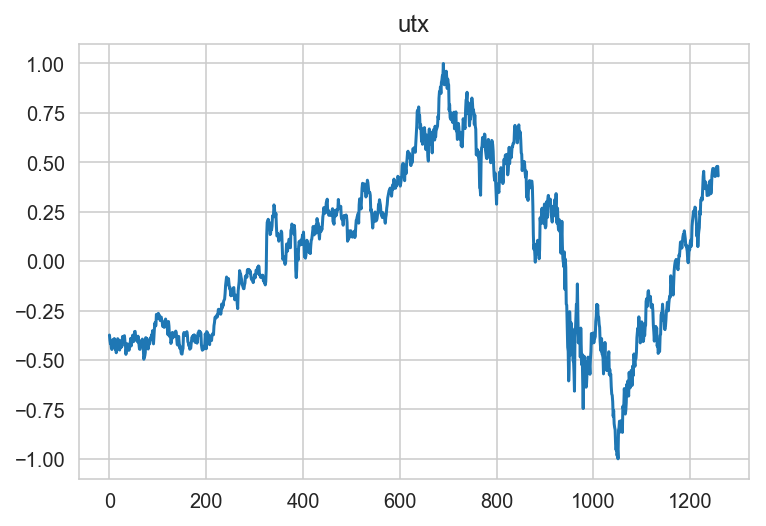

In [6]:
for c in stocks_norm.columns:
    stocks_norm[c].plot()
    plt.title(c)
    plt.show()

### 6. Split the data into training and testing subsets

Make sure the test set is all future data (timepoints beyond the training data).

In [7]:
train_size = int(stocks_norm.shape[0] * 0.75)
test_size = stocks_norm.shape[0] - train_size
print(stocks_norm.shape[0], train_size, test_size)

train, test = stocks_norm.iloc[0:train_size,:], stocks_norm.iloc[train_size:,:]

1259 944 315


### 7. Create an X and Y matrix where the predictor matrix X are the changes lagged one behind Y.

A cool aspect of LSTMs and neural network architectures in general is that it is trivial to fit models with multiple outputs.

Here our target will be a *matrix* of tomorrows price changes, and the predictors will be a matrix of todays stock changes. Thus we are going to optimize the neural network to minimize the error predicting the next stock change on all of the stocks at the same time!

Create the X and Y below.

In [8]:
def create_XY(df):
    Y = df.iloc[1:, :]
    X = df.iloc[:-1, :]
    return X.values, Y.values

In [9]:
Xtrain, Ytrain = create_XY(train)
Xtest, Ytest = create_XY(test)

In [10]:
print(Xtrain.shape, Ytrain.shape)
print(Xtest.shape, Ytest.shape)

(943, 8) (943, 8)
(314, 8) (314, 8)


### 8. Reshape the training and testing X to be 3D

Recall that the LSTM takes a tensor in format:

    [observations, timesteps, features]
    
We lagged this only 1, so we will only have 1 timestep per feature (we will be using a stateful LSTM for fitting so we don't actually need more than 1 timestep).

> *Hint: the `np.reshape` function can add the 3rd dimension to your data.*

In [11]:
# reshape input to be [samples, time steps, features]
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], 1, Xtrain.shape[1]))
Xtest = np.reshape(Xtest, (Xtest.shape[0], 1, Xtest.shape[1]))

### 9. Build a Keras LSTM model

Below is some code that will build an LSTM model for this forecasting problem:

```python
model = Sequential()
# Remember: "batch_input_shape" and specify the batch size
model.add(LSTM(32, batch_input_shape=(1, 1, Xtrain.shape[2]), stateful=True))
model.add(Dense(Xtrain.shape[2]))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
```

Some things to note:
- The `stateful=True` indicates that our LSTM layer is stateful and will need to be manually reset. This allows us to feed in all the observations sequentially and allow the LSTM to (possibly) find signal in temporal patterns.
- We have 32 LSTM neurons. The `batch_input_shape=(1, 1, Xtrain.shape[2])` specifies the expected input to this layer. There will be 1 observation at a time, with 1 timestep, and as many features as there are in Xtrain.
- The `model.add(Dense(Xtrain.shape[2]))` adds the final output layer with as many output neurons as there are features. When we fit the model we will be predicting the matrix Y that has the same number of columns. This is the portion that allows us to fit on multiple outputs.

In [12]:
# create and fit the LSTM network
model = Sequential()
# Remember: "batch_input_shape" and specify the batch size
model.add(LSTM(32, batch_input_shape=(1, 1, Xtrain.shape[2]), stateful=True))
model.add(Dense(Xtrain.shape[2]))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 32)                   5248      
_________________________________________________________________
dense_1 (Dense)              (1, 8)                    264       
Total params: 5,512
Trainable params: 5,512
Non-trainable params: 0
_________________________________________________________________


### 10. Fit the stateful LSTM model

Below is code to help you fit the model outlined above:

```python
for i in range(100):
    if (i % 5) == 0:
        print 'ITER:', i
        model.fit(Xtrain, Ytrain, nb_epoch=1, batch_size=1, verbose=1, shuffle=False)
    else:
        model.fit(Xtrain, Ytrain, nb_epoch=1, batch_size=1, verbose=0, shuffle=False)
    model.reset_states()
```

Here we will iterate over the entire training data 100 times. Each time we will fit the model without shuffling the data, feeding in single observations sequentially (batch_size=1).

The if-else statement inside allows us to print out every 5 iterations. Notice the `model.reset_states()`. This is where we manually clear the internal state of the LSTM neurons after each pass through the data.

In [14]:
for i in range(100):
    if (i % 5) == 0:
        print('ITER:', i)
        model.fit(Xtrain, Ytrain, epochs=1, batch_size=1, verbose=1, shuffle=False)
    else:
        model.fit(Xtrain, Ytrain, epochs=1, batch_size=1, verbose=0, shuffle=False)
    model.reset_states()

ITER: 0
Epoch 1/1
943/943 [==============================] - 3s 3ms/step - loss: 0.0148
ITER: 5
Epoch 1/1
943/943 [==============================] - 3s 3ms/step - loss: 0.0083
ITER: 10
Epoch 1/1
943/943 [==============================] - 3s 3ms/step - loss: 0.0063
ITER: 15
Epoch 1/1
943/943 [==============================] - 3s 3ms/step - loss: 0.0046
ITER: 20
Epoch 1/1
943/943 [==============================] - 3s 3ms/step - loss: 0.0037
ITER: 25
Epoch 1/1
943/943 [==============================] - 3s 3ms/step - loss: 0.0031
ITER: 30
Epoch 1/1
943/943 [==============================] - 3s 3ms/step - loss: 0.0029
ITER: 35
Epoch 1/1
943/943 [==============================] - 3s 3ms/step - loss: 0.0027
ITER: 40
Epoch 1/1
943/943 [==============================] - 3s 3ms/step - loss: 0.0035
ITER: 45
Epoch 1/1
943/943 [==============================] - 3s 3ms/step - loss: 0.0029
ITER: 50
Epoch 1/1
943/943 [==============================] - 3s 3ms/step - loss: 0.0027
ITER: 55
Epoch 1/1
943/

*NOTE*: the proper way of doing this step is to add the validation_data to the train function! The risk otherwise is to overfit!

### 11. Plot the forecast on the testing data

Plot out the testing data and the forecast from the LSTM prediction. You will need to predict on the X test data.

Remember that the LSTM is now making a prediction for each of the stocks, so the prediction will be a matrix. To plot an individual stock, you will need to pull out the column corresponding to that stock.

> **Note:** as this is a fairly challenging plotting problem, I have provided template plotting code below. It is similar to the plotting code outlined in the LSTM forecasting lecture.

In [15]:
from sklearn.metrics import r2_score

def plot_all(model, Xtrain, Xtest, Ytest, stocks, stocks_names):
    train_hat = model.predict(Xtrain, batch_size=1)
    model.reset_states()
    test_hat = model.predict(Xtest, batch_size=1)
    model.reset_states()
    
    train_plot = np.empty_like(stocks.values)
    train_plot[:, :] = np.nan
    train_plot[1:Xtrain.shape[0]+1, :] = train_hat
    
    test_plot = np.empty_like(stocks.values)
    test_plot[:, :] = np.nan
    test_plot[-Xtest.shape[0]:, :] = test_hat
    
    fig, axarr = plt.subplots(Ytest.shape[1], 1, figsize=(12,24))
    
    for i in range(Ytest.shape[1]):
        axarr[i].plot(stocks.iloc[:,i], color='grey', alpha=0.7)
        axarr[i].plot(train_plot[:,i])
        axarr[i].plot(test_plot[:,i])
        test_r2 = r2_score(Ytest[:,i], test_hat[:,i])
        axarr[i].set_title(stocks_names[i]+' test R2: '+str(test_r2))
        
    plt.show()

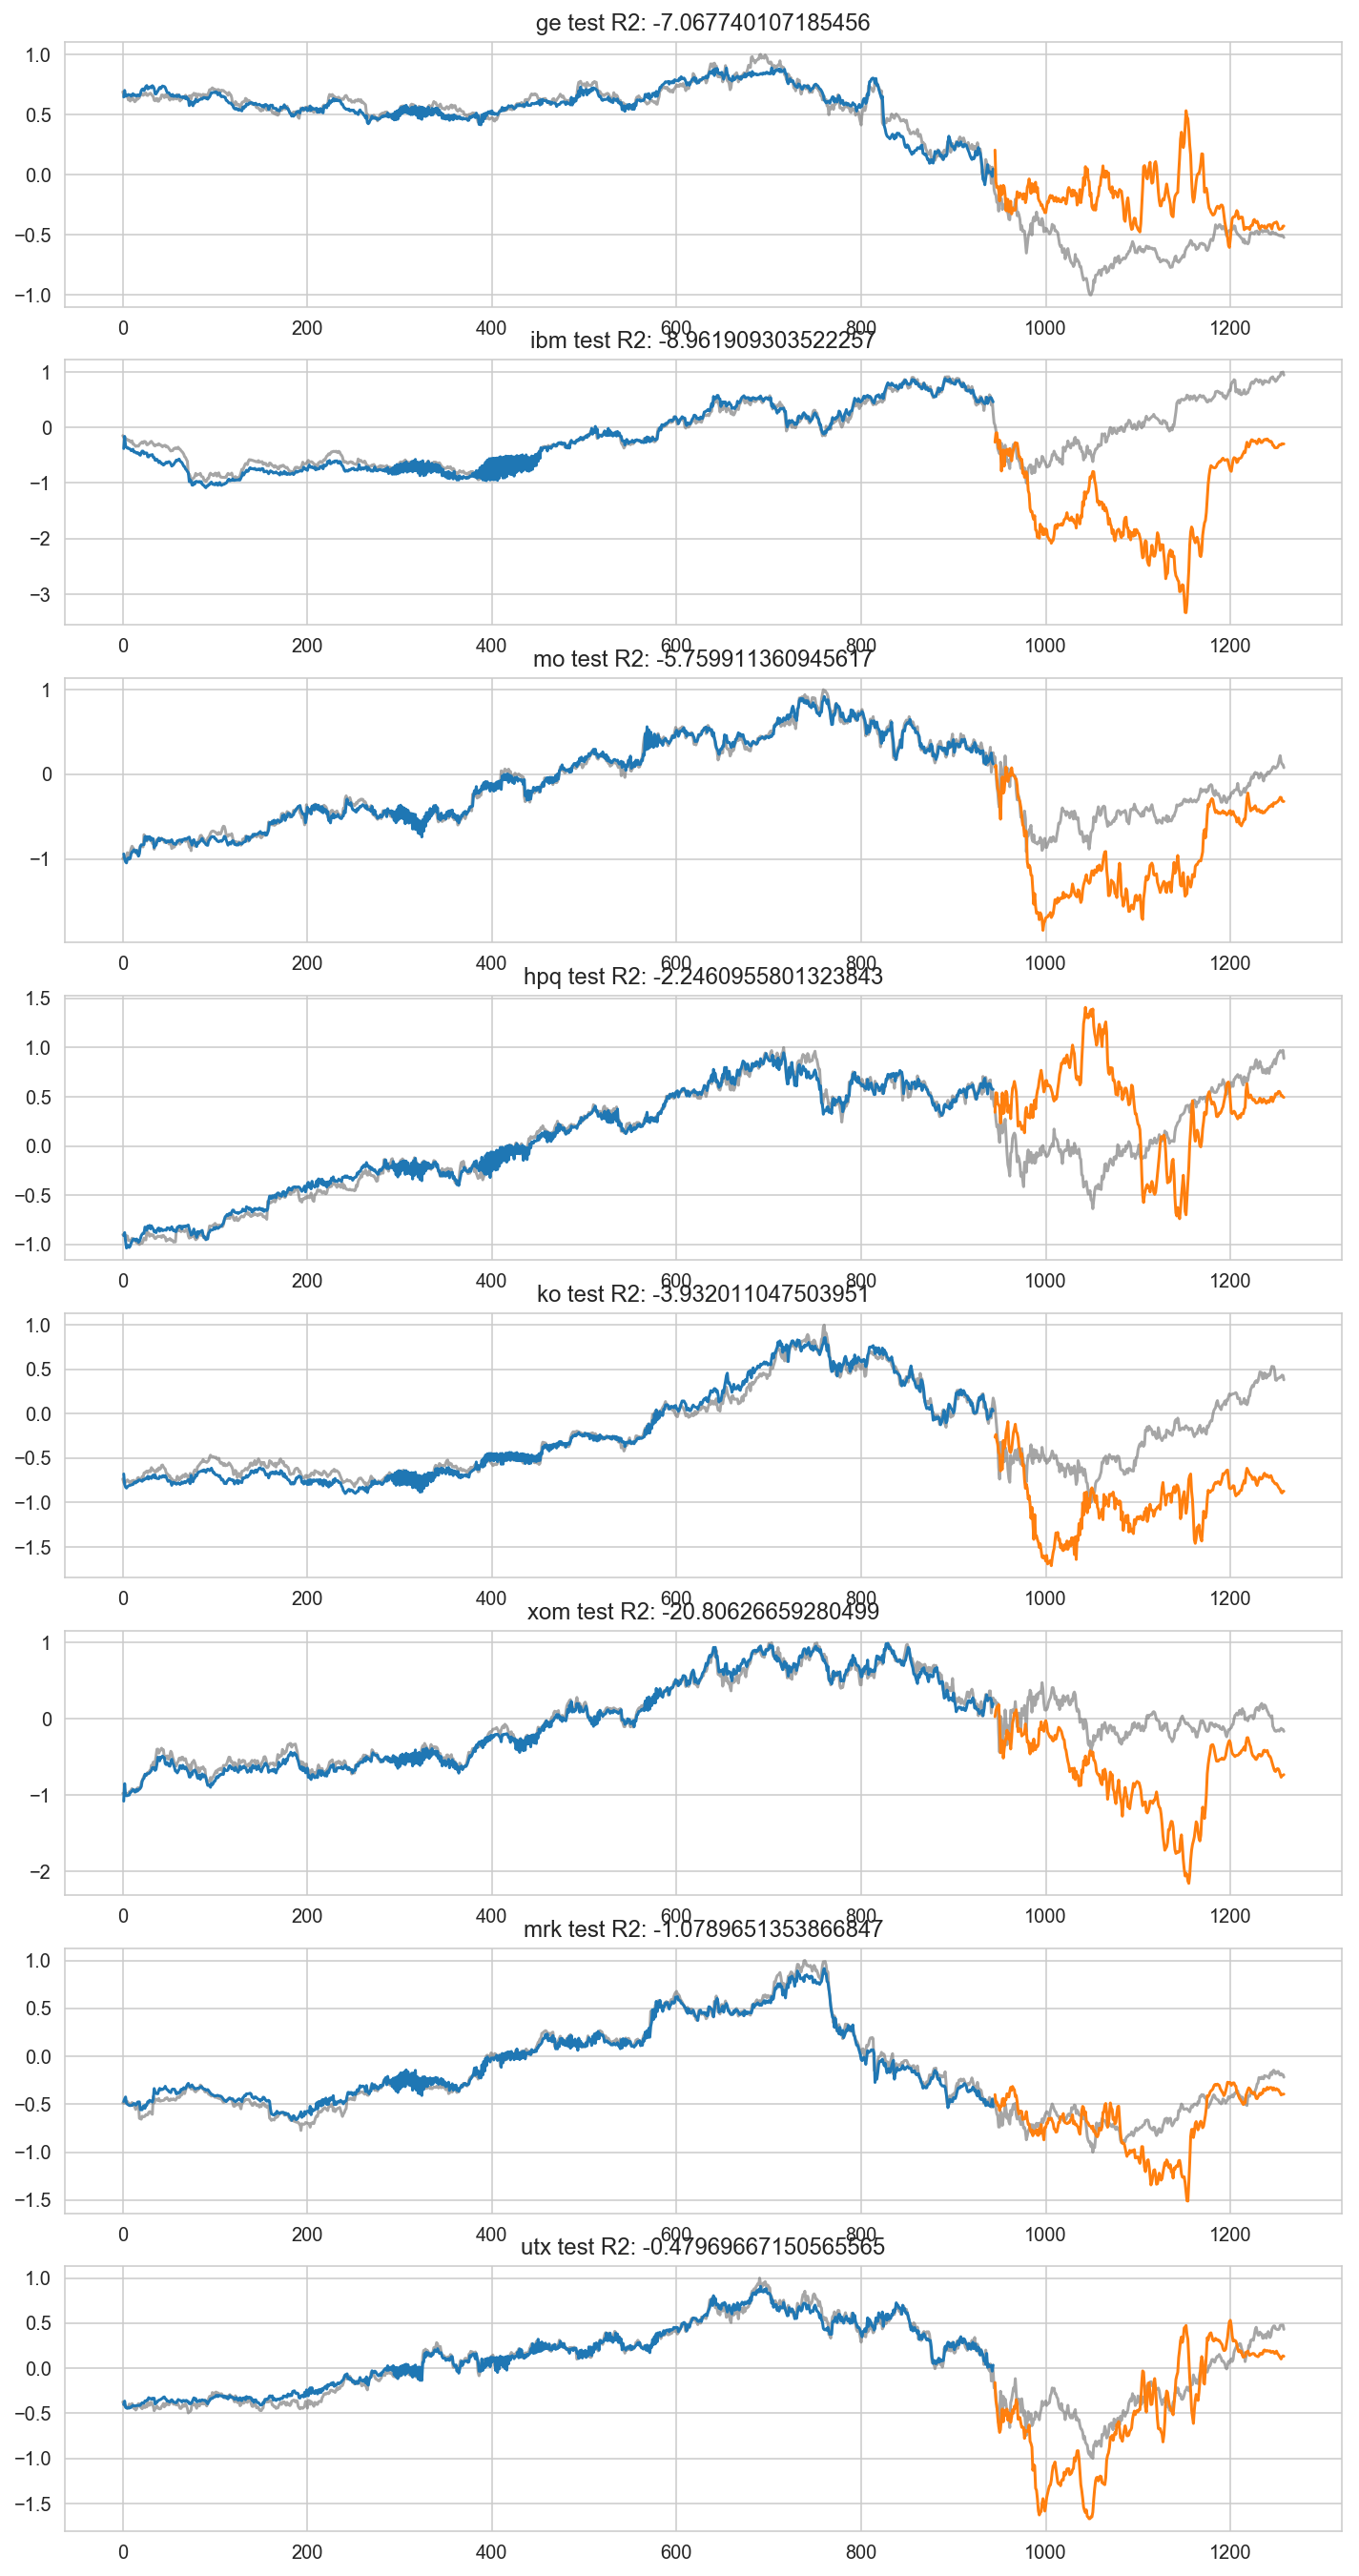

In [16]:
plot_all(model, Xtrain, Xtest, Ytest, stocks_norm, stocks_norm.columns)

### 12. [Bonus] Build another LSTM model of your choice.

There are many ways you could change things up. Consider:
1. Changing the stocks in the predictor matrix or target.
2. Adding layers to the neural network architecture (check out the Keras documentation or examples!)

In [17]:
# create and fit the LSTM network
model = Sequential()
# Remember: "batch_input_shape" and specify the batch size
model.add(LSTM(64, batch_input_shape=(1, 1, Xtrain.shape[2]), 
               stateful=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(32, stateful=True, return_sequences=False))
model.add(Dense(Xtrain.shape[2]))
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (1, 1, 64)                18688     
_________________________________________________________________
lstm_3 (LSTM)                (1, 32)                   12416     
_________________________________________________________________
dense_2 (Dense)              (1, 8)                    264       
Total params: 31,368
Trainable params: 31,368
Non-trainable params: 0
_________________________________________________________________


In [20]:
for i in range(20): #maybe 20 is not optimal!
    if (i % 5) == 0:
        print('ITER:', i)
        model.fit(Xtrain, Ytrain, epochs=1, batch_size=1, verbose=1, shuffle=False)
    else:
        model.fit(Xtrain, Ytrain, epochs=1, batch_size=1, verbose=0, shuffle=False)
    model.reset_states()

ITER: 0
Epoch 1/1
943/943 [==============================] - 4s 5ms/step - loss: 0.0120
ITER: 5
Epoch 1/1
943/943 [==============================] - 4s 5ms/step - loss: 0.0054
ITER: 10
Epoch 1/1
943/943 [==============================] - 4s 5ms/step - loss: 0.0068
ITER: 15
Epoch 1/1
943/943 [==============================] - 4s 4ms/step - loss: 0.0064


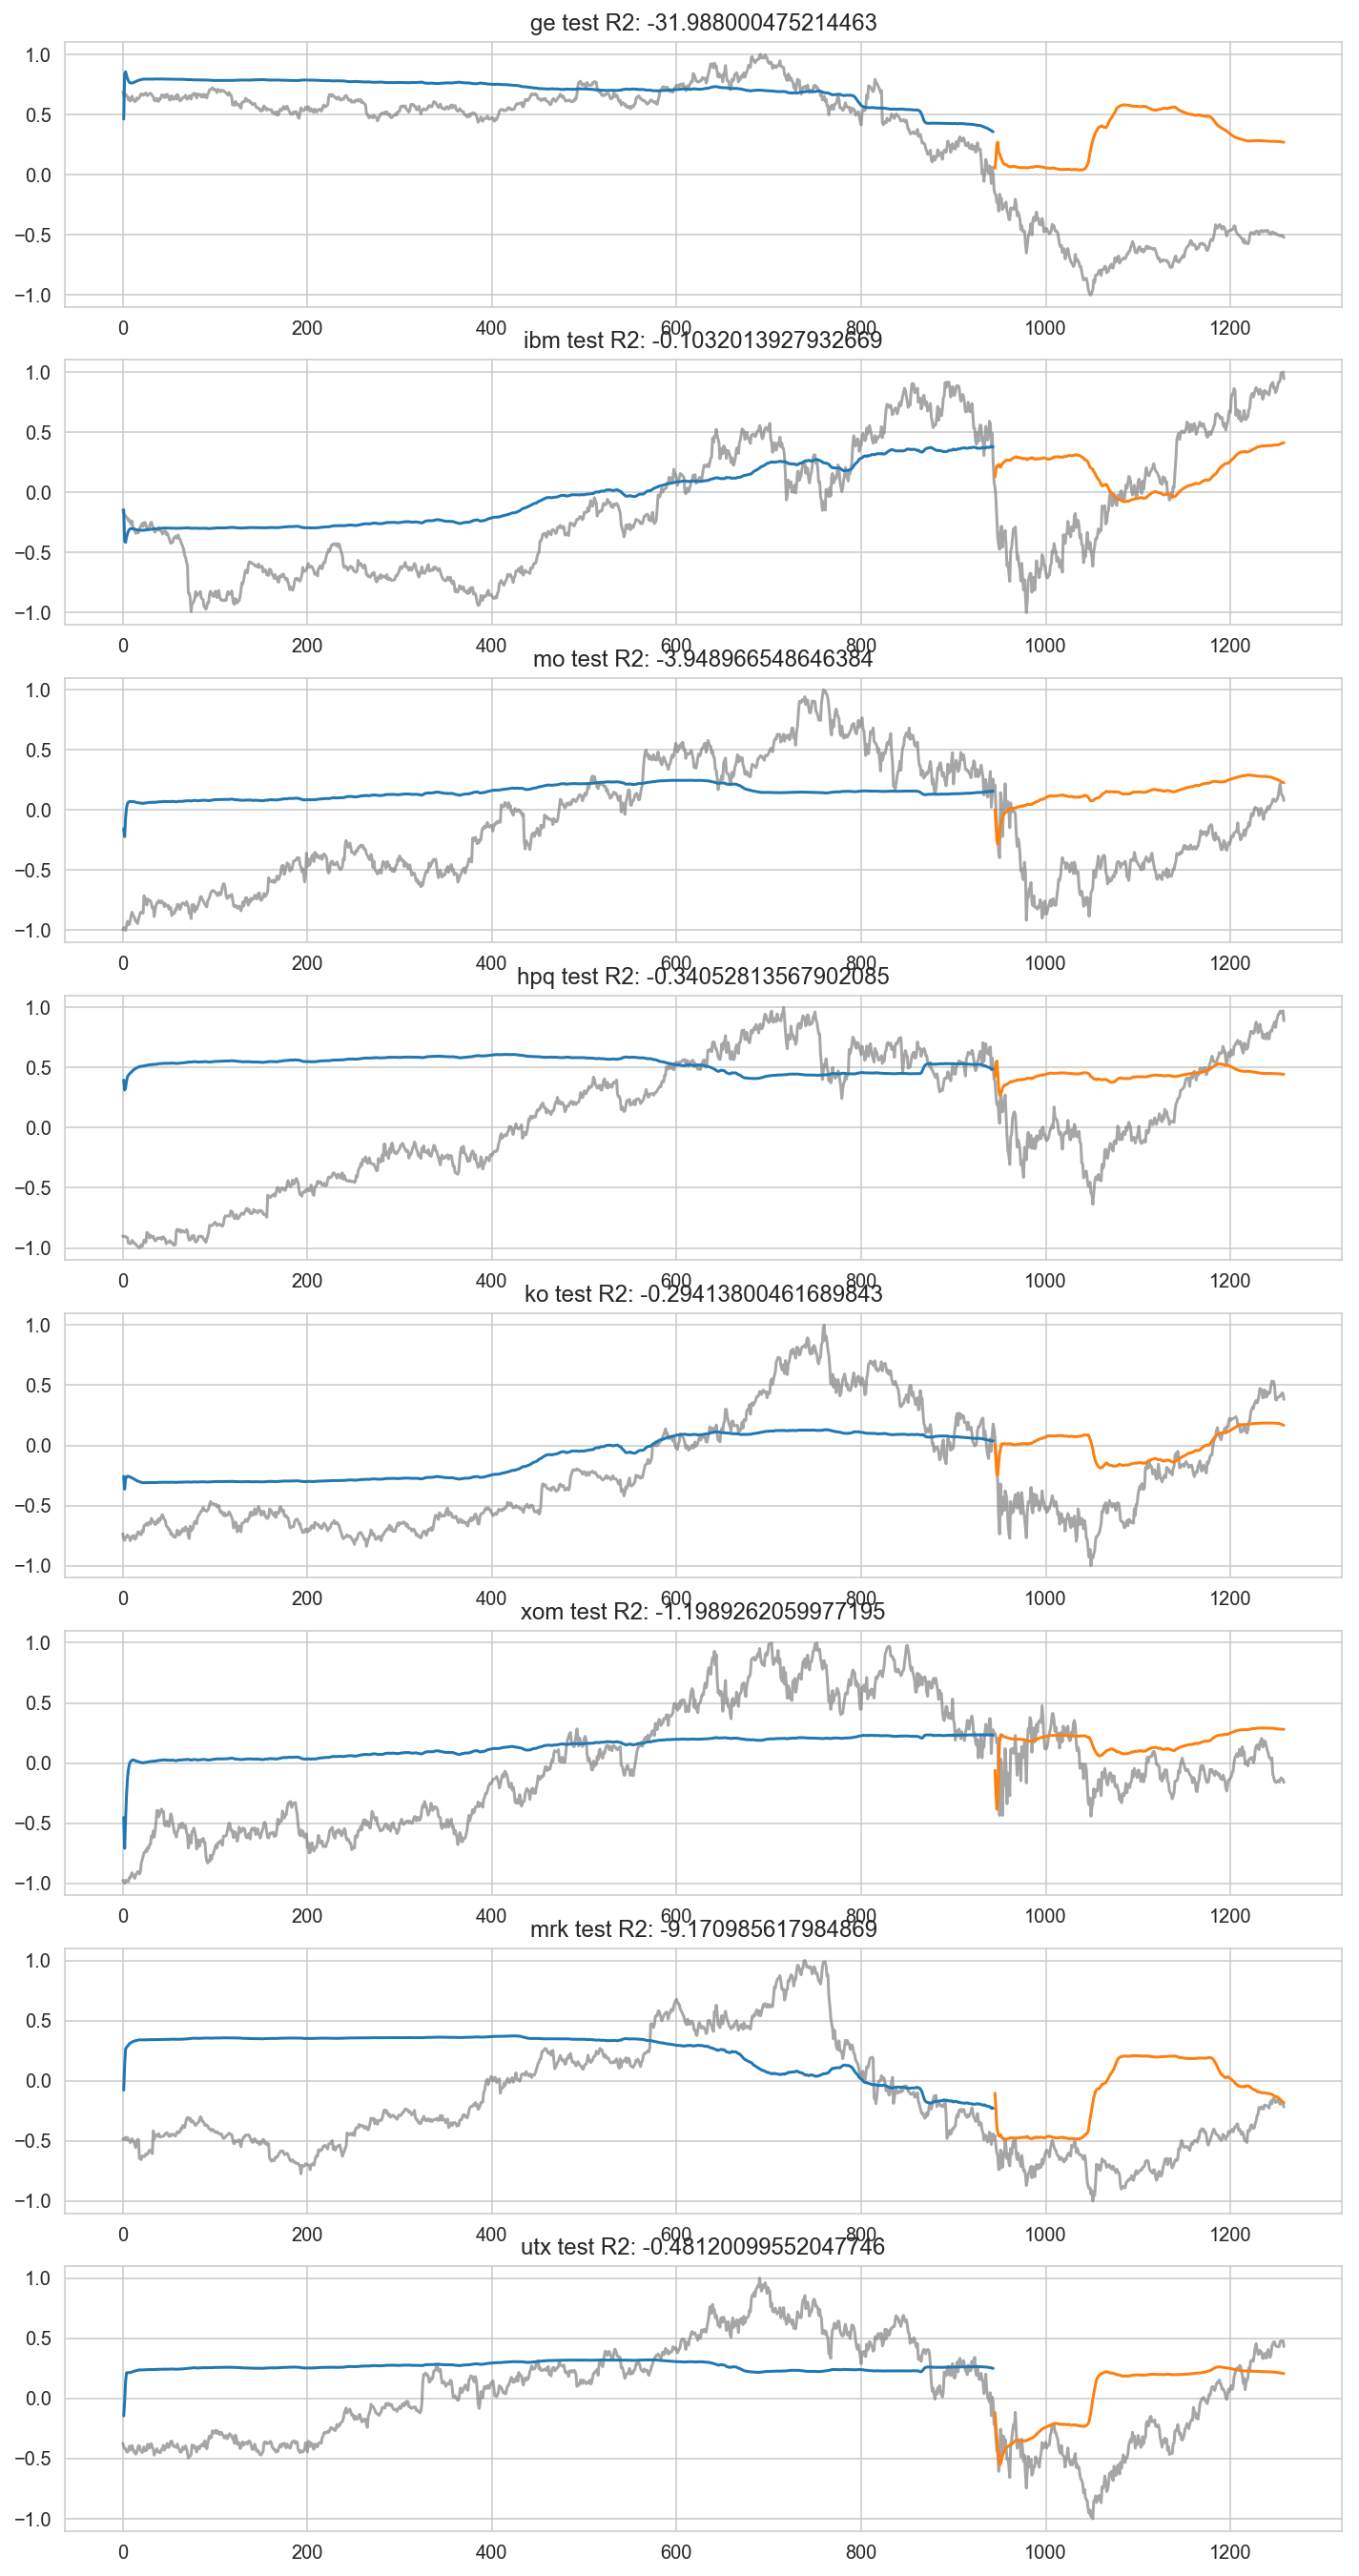

In [21]:
plot_all(model, Xtrain, Xtest, Ytest, stocks_norm, stocks_norm.columns)

Underfitting?